## Alpha
Mosfet I-V

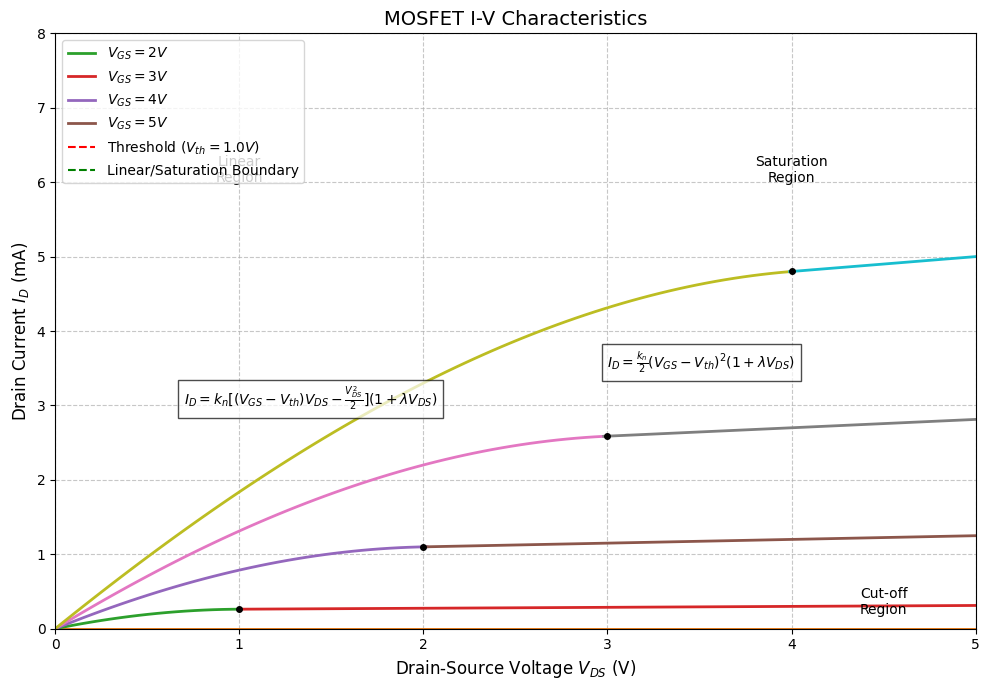

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D

# MOSFET parameters
k_n = 0.5  # Process transconductance parameter (mA/V^2)
V_th = 1.0  # Threshold voltage (V)
lambda_param = 0.05  # Channel length modulation parameter (V^-1)

# Voltage ranges
V_gs_values = np.array([0, 1, 2, 3, 4, 5])  # Gate-source voltages
V_ds_range = np.linspace(0, 5, 100)  # Drain-source voltage sweep

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 7))

# Function to calculate drain current in linear region
def I_d_linear(V_gs, V_ds):
    if V_gs <= V_th:
        return 0
    else:
        return k_n * ((V_gs - V_th) * V_ds - V_ds**2/2) * (1 + lambda_param * V_ds)

# Function to calculate drain current in saturation region
def I_d_saturation(V_gs, V_ds):
    if V_gs <= V_th:
        return 0
    else:
        return (k_n/2) * (V_gs - V_th)**2 * (1 + lambda_param * V_ds)

# Function to calculate current for all regions
def I_d_all_regions(V_gs, V_ds):
    if V_gs <= V_th:
        return 0  # Cut-off region
    elif V_ds <= V_gs - V_th:
        return I_d_linear(V_gs, V_ds)  # Linear region
    else:
        return I_d_saturation(V_gs, V_ds)  # Saturation region

# Calculate currents for each V_gs value
for V_gs in V_gs_values:
    I_d_values = np.array([I_d_all_regions(V_gs, vds) for vds in V_ds_range])
    
    # Calculate transition point between linear and saturation regions
    if V_gs > V_th:
        V_ds_transition = V_gs - V_th
        transition_index = np.argmin(np.abs(V_ds_range - V_ds_transition))
        
        # Plot with different styles for the two regions
        ax.plot(V_ds_range[:transition_index+1], I_d_values[:transition_index+1], 
                linestyle='-', linewidth=2, label=f'$V_{{GS}} = {V_gs}V$' if V_gs == V_gs_values[-1] else None)
        ax.plot(V_ds_range[transition_index:], I_d_values[transition_index:], 
                linestyle='-', linewidth=2)
        
        # Mark transition point
        ax.plot(V_ds_transition, I_d_all_regions(V_gs, V_ds_transition), 'o', markersize=4, color='black')
    else:
        ax.plot(V_ds_range, I_d_values, linestyle='-', linewidth=2, 
                label=f'$V_{{GS}} = {V_gs}V$ (Cut-off)' if V_gs == V_gs_values[0] else None)

# Add boundary line for threshold voltage
# V_ds_threshold = np.linspace(0, 5, 100)
# threshold_current = np.array([I_d_all_regions(V_th, vds) for vds in V_ds_threshold])
# ax.plot(V_ds_threshold, threshold_current, 'r--', linewidth=1.5, label=f'Threshold ($V_{{th}} = {V_th}V$)')

# Add region labels
ax.text(4.5, 0.2, 'Cut-off\nRegion', fontsize=10, ha='center')
ax.text(1.0, 6.0, 'Linear\nRegion', fontsize=10, ha='center')
ax.text(4.0, 6.0, 'Saturation\nRegion', fontsize=10, ha='center')

# Add boundary line between linear and saturation regions
# boundary_x = np.linspace(0, 5, 100)
# boundary_y = np.array([V_th + x for x in boundary_x])
# mask = boundary_y <= max(V_gs_values)
# ax.plot(boundary_x[mask], boundary_y[mask], 'g--', linewidth=1.5, label='Linear/Saturation Boundary')

# Add annotations for equations
linear_eq = r'$I_D = k_n[(V_{GS} - V_{th})V_{DS} - \frac{V_{DS}^2}{2}](1 + \lambda V_{DS})$'
ax.text(0.7, 3.0, linear_eq, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

sat_eq = r'$I_D = \frac{k_n}{2}(V_{GS} - V_{th})^2(1 + \lambda V_{DS})$'
ax.text(3.0, 3.5, sat_eq, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

# Create custom legend elements for the different V_GS values
legend_elements = []
for i, V_gs in enumerate(V_gs_values):
    if V_gs <= V_th:
        continue  # Skip cut-off in legend to avoid clutter
    legend_elements.append(Line2D([0], [0], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], 
                                 lw=2, label=f'$V_{{GS}} = {V_gs}V$'))

# Add other legend elements
legend_elements.append(Line2D([0], [0], color='r', linestyle='--', lw=1.5, 
                           label=f'Threshold ($V_{{th}} = {V_th}V$)'))
legend_elements.append(Line2D([0], [0], color='g', linestyle='--', lw=1.5, 
                           label='Linear/Saturation Boundary'))

# Add the legend
ax.legend(handles=legend_elements, loc='upper left')

# Setting labels and title
ax.set_xlabel('Drain-Source Voltage $V_{DS}$ (V)', fontsize=12)
ax.set_ylabel('Drain Current $I_D$ (mA)', fontsize=12)
ax.set_title('MOSFET I-V Characteristics', fontsize=14)

# Setting axis limits
ax.set_xlim(0, 5)
ax.set_ylim(0, 8)

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
#plt.savefig("mosfet-IV.png")
plt.show()

## Beta
Attempt to model polarization of oxide

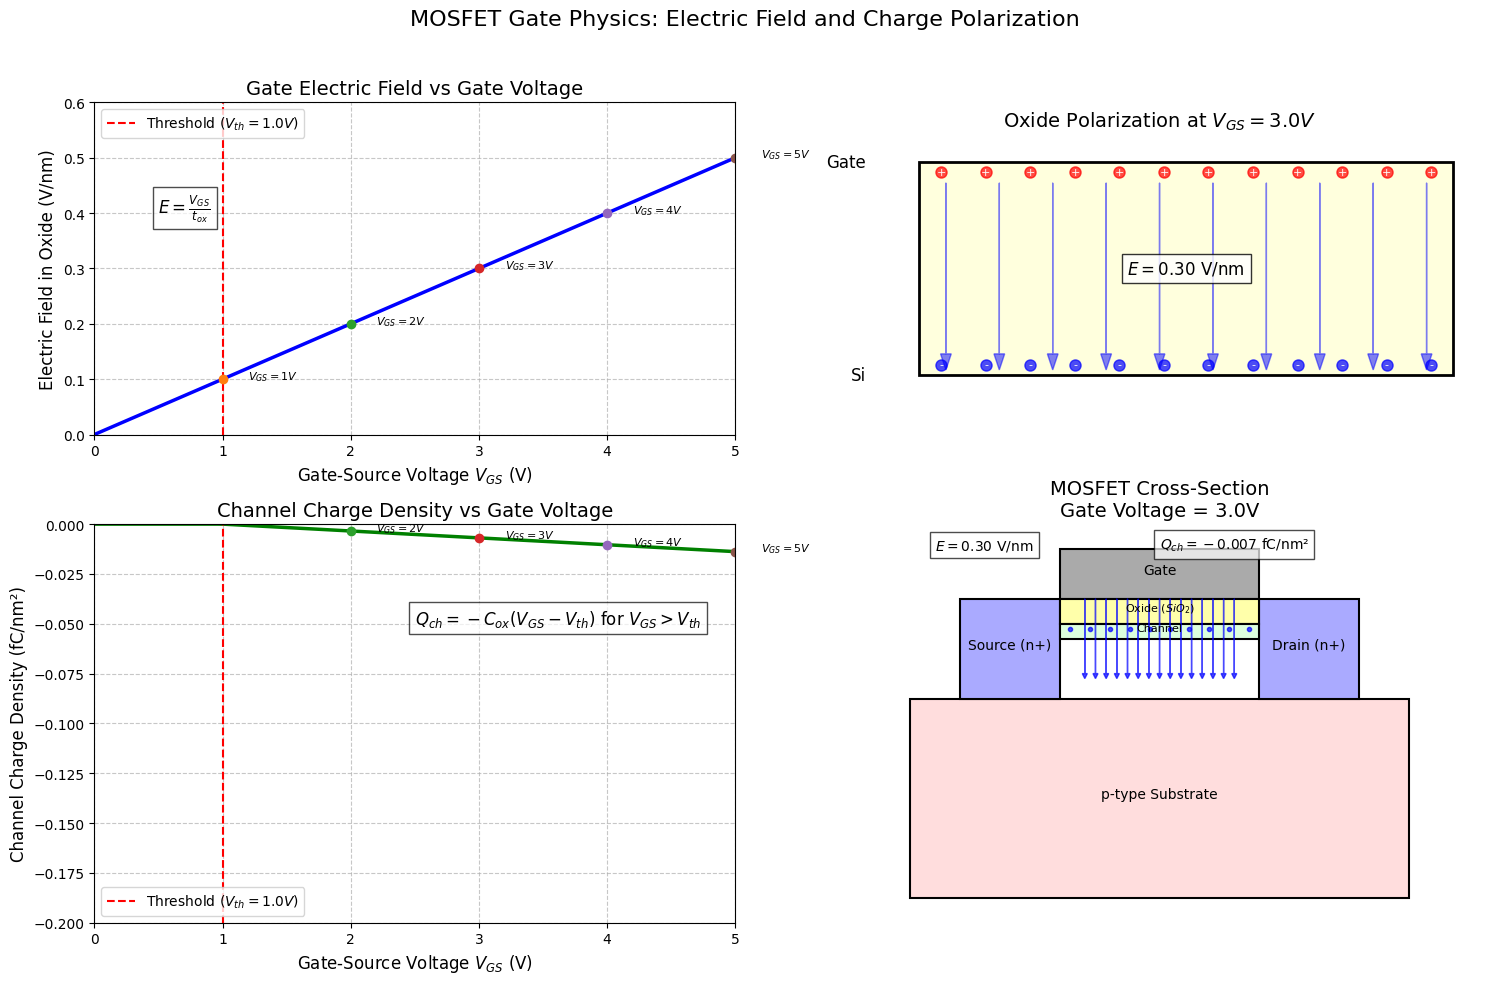

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

# Create a figure with GridSpec for layout control
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.2], width_ratios=[1, 1])

# MOSFET parameters
V_th = 1.0  # Threshold voltage (V)
t_ox = 10  # Oxide thickness (nm)
epsilon_ox = 3.9 * 8.85e-3  # Oxide permittivity (ε_ox * ε_0) in fF/nm
C_ox = epsilon_ox / t_ox  # Oxide capacitance per unit area (fF/nm²)

# Voltage ranges
V_gs_values = np.array([0, 1, 2, 3, 4, 5])  # Gate-source voltages for specific points
V_gs_range = np.linspace(0, 5, 100)  # Continuous gate voltage range

# Function to calculate electric field in the oxide
def E_field(V_gs):
    return V_gs / t_ox  # E-field in V/nm

# Function to calculate charge density in the channel
def Q_channel(V_gs):
    if V_gs <= V_th:
        return 0
    else:
        return -C_ox * (V_gs - V_th)  # Channel charge density (fC/nm²), negative for electrons

# Electric Field vs Gate Voltage Plot (Top Left)
ax1 = fig.add_subplot(gs[0, 0])

# Calculate electric field for different gate voltages
E_field_values = np.array([E_field(vgs) for vgs in V_gs_range])

# Plot E-field vs V_gs
ax1.plot(V_gs_range, E_field_values, 'b-', linewidth=2.5)

# Add threshold voltage vertical line
ax1.axvline(x=V_th, color='r', linestyle='--', linewidth=1.5, 
            label=f'Threshold ($V_{{th}} = {V_th}V$)')

# Mark specific points
for vgs in V_gs_values:
    if vgs > 0:  # Skip 0V to avoid clutter
        e_field = E_field(vgs)
        ax1.plot(vgs, e_field, 'o', markersize=6, 
                color=plt.rcParams['axes.prop_cycle'].by_key()['color'][np.where(V_gs_values == vgs)[0][0]])
        # Add annotation
        ax1.annotate(f'$V_{{GS}}={vgs}V$', 
                    xy=(vgs, e_field), xytext=(vgs+0.2, e_field),
                    fontsize=8)

# Setting labels and title
ax1.set_xlabel('Gate-Source Voltage $V_{GS}$ (V)', fontsize=12)
ax1.set_ylabel('Electric Field in Oxide (V/nm)', fontsize=12)
ax1.set_title('Gate Electric Field vs Gate Voltage', fontsize=14)

# Add E-field equation
e_field_eq = r'$E = \frac{V_{GS}}{t_{ox}}$'
ax1.text(0.5, 0.4, e_field_eq, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

# Add grid and legend
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')

# Setting axis limits
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 0.6)

# Oxide Polarization Visualization (Top Right)
ax2 = fig.add_subplot(gs[0, 1])

# Create a function to visualize the polarization in the oxide for a given gate voltage
def draw_oxide_polarization(ax, V_gs):
    # Define oxide dimensions
    width = 10
    height = 4
    
    # Create oxide rectangle
    oxide = Rectangle((0, 0), width, height, fc='#FFFFDD', ec='k', lw=2)
    ax.add_patch(oxide)
    
    # Label top and bottom of oxide
    ax.text(-1, height, 'Gate', fontsize=12, ha='right', va='center')
    ax.text(-1, 0, 'Si', fontsize=12, ha='right', va='center')
    
    # Draw positive charges (holes) at the top of the oxide
    if V_gs > 0:
        charge_density = min(1.0, V_gs / 5.0)  # Normalize to max V_gs
        num_charges = int(20 * charge_density)
        
        for i in range(num_charges):
            x_pos = width * (i + 0.5) / num_charges
            # Top (positive charges)
            ax.plot(x_pos, height-0.2, 'o', markersize=8, color='red', alpha=0.7)
            ax.text(x_pos, height-0.2, '+', color='white', ha='center', va='center', fontsize=8)
            
            # Bottom (negative charges)
            ax.plot(x_pos, 0.2, 'o', markersize=8, color='blue', alpha=0.7)
            ax.text(x_pos, 0.2, '-', color='white', ha='center', va='center', fontsize=8)
        
        # Draw electric field lines
        num_lines = min(10, num_charges)
        for i in range(num_lines):
            x_pos = width * (i + 0.5) / num_lines
            arrow_length = height - 0.8
            ax.arrow(x_pos, height-0.4, 0, -arrow_length, head_width=0.2, head_length=0.3, 
                    fc='blue', ec='blue', alpha=0.5)
    
    # Title and axis settings
    ax.set_title(f'Oxide Polarization at $V_{{GS}} = {V_gs}V$', fontsize=14)
    ax.set_xlim(-1.5, width+0.5)
    ax.set_ylim(-0.5, height+0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Add electric field value
    if V_gs > 0:
        e_value = E_field(V_gs)
        ax.text(width/2, height/2, f'$E = {e_value:.2f}$ V/nm', fontsize=12, 
                ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))

# Draw for a specific gate voltage
draw_oxide_polarization(ax2, 3.0)

# Channel Charge Density vs Gate Voltage Plot (Bottom Left)
ax3 = fig.add_subplot(gs[1, 0])

# Calculate channel charge for different gate voltages
Q_values = np.array([Q_channel(vgs) for vgs in V_gs_range])

# Plot charge vs V_gs
ax3.plot(V_gs_range, Q_values, 'g-', linewidth=2.5)

# Add threshold voltage vertical line
ax3.axvline(x=V_th, color='r', linestyle='--', linewidth=1.5, 
            label=f'Threshold ($V_{{th}} = {V_th}V$)')

# Mark specific points
for vgs in V_gs_values:
    if vgs > V_th:  # Only mark points above threshold
        q_channel = Q_channel(vgs)
        ax3.plot(vgs, q_channel, 'o', markersize=6, 
                color=plt.rcParams['axes.prop_cycle'].by_key()['color'][np.where(V_gs_values == vgs)[0][0]])
        # Add annotation
        ax3.annotate(f'$V_{{GS}}={vgs}V$', 
                    xy=(vgs, q_channel), xytext=(vgs+0.2, q_channel),
                    fontsize=8)

# Setting labels and title
ax3.set_xlabel('Gate-Source Voltage $V_{GS}$ (V)', fontsize=12)
ax3.set_ylabel('Channel Charge Density (fC/nm²)', fontsize=12)
ax3.set_title('Channel Charge Density vs Gate Voltage', fontsize=14)

# Add charge equation
charge_eq = r'$Q_{ch} = -C_{ox}(V_{GS} - V_{th})$ for $V_{GS} > V_{th}$'
ax3.text(2.5, -0.05, charge_eq, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

# Add grid and legend
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.legend(loc='lower left')

# Setting axis limits
ax3.set_xlim(0, 5)
ax3.set_ylim(-0.2, 0)

# MOSFET Cross-Section with E-field Visualization (Bottom Right)
ax4 = fig.add_subplot(gs[1, 1])

# Selected V_gs for visualization
selected_V_gs = 3.0  # V

# Draw MOSFET structure
# Dimensions in arbitrary units for visualization
width = 10
height = 6
gate_width = 4
oxide_height = 0.5
channel_height = 0.3

# Define components
substrate = Rectangle((0, 0), width, height-2, fc='#FFDDDD', ec='k', lw=1.5)
source = Rectangle((1, height-2), 2, 2, fc='#AAAAFF', ec='k', lw=1.5)
drain = Rectangle((width-3, height-2), 2, 2, fc='#AAAAFF', ec='k', lw=1.5)
gate = Rectangle((width/2-gate_width/2, height), gate_width, 1, fc='#AAAAAA', ec='k', lw=1.5)
oxide = Rectangle((width/2-gate_width/2, height-oxide_height), gate_width, oxide_height, fc='#FFFFAA', ec='k', lw=1.5)
channel = Rectangle((width/2-gate_width/2, height-oxide_height-channel_height), gate_width, channel_height, fc='#DDFFDD', ec='k', lw=1.5)

# Add components to the plot
ax4.add_patch(substrate)
ax4.add_patch(source)
ax4.add_patch(drain)
ax4.add_patch(gate)
ax4.add_patch(oxide)
ax4.add_patch(channel)

# Add labels
ax4.text(width/2, height+0.5, 'Gate', ha='center')
ax4.text(2, height-1, 'Source (n+)', ha='center')
ax4.text(width-2, height-1, 'Drain (n+)', ha='center')
ax4.text(width/2, height-oxide_height/2, 'Oxide ($SiO_2$)', ha='center', fontsize=8)
ax4.text(width/2, height-oxide_height-channel_height/2, 'Channel', ha='center', fontsize=8)
ax4.text(width/2, height/2-1, 'p-type Substrate', ha='center')

# Visualize electric field lines
if selected_V_gs > 0:
    # Draw electric field lines from gate to channel
    num_lines = 15
    line_positions = np.linspace(width/2-gate_width/2+0.5, width/2+gate_width/2-0.5, num_lines)
    
    # Adjust field intensity based on gate voltage
    field_intensity = selected_V_gs / V_th if selected_V_gs > V_th else selected_V_gs / (2*V_th)
    arrow_length = oxide_height * field_intensity
    
    for x_pos in line_positions:
        # Draw field line from gate to channel
        ax4.arrow(x_pos, height, 0, -arrow_length, head_width=0.1, head_length=0.1, 
                 fc='blue', ec='blue', alpha=0.7)
    
    # Draw charge accumulation at the interface
    if selected_V_gs > V_th:
        charge_density = abs(Q_channel(selected_V_gs)) / abs(Q_channel(5))  # Normalize to max charge
        for x_pos in np.linspace(width/2-gate_width/2+0.2, width/2+gate_width/2-0.2, int(20*charge_density)):
            ax4.plot(x_pos, height-oxide_height-0.1, 'o', markersize=3, color='#0000FF', alpha=0.7)

# Add a title with selected gate voltage
ax4.set_title(f'MOSFET Cross-Section\nGate Voltage = {selected_V_gs}V', fontsize=14)

# Setting axis properties
ax4.set_aspect('equal')
ax4.set_xlim(-0.5, width+0.5)
ax4.set_ylim(-0.5, height+1.5)
ax4.axis('off')

# Add annotations for electric field and charge
if selected_V_gs > 0:
    # E-field equation
    e_value = E_field(selected_V_gs)
    ax4.text(0.5, height+1, f'$E = {e_value:.2f}$ V/nm', fontsize=10, 
             bbox=dict(facecolor='white', alpha=0.7))
    
    # Charge equation if above threshold
    if selected_V_gs > V_th:
        q_value = Q_channel(selected_V_gs)
        ax4.text(width-5, height+1, f'$Q_{{ch}} = {q_value:.3f}$ fC/nm²', fontsize=10, 
                 bbox=dict(facecolor='white', alpha=0.7))

# Add overall title explaining the physics
fig.suptitle('MOSFET Gate Physics: Electric Field and Charge Polarization', fontsize=16, y=0.98)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for suptitle
plt.show()

## Charlie
Changing things around
Plot for E ind vs E ext

Channel charge density

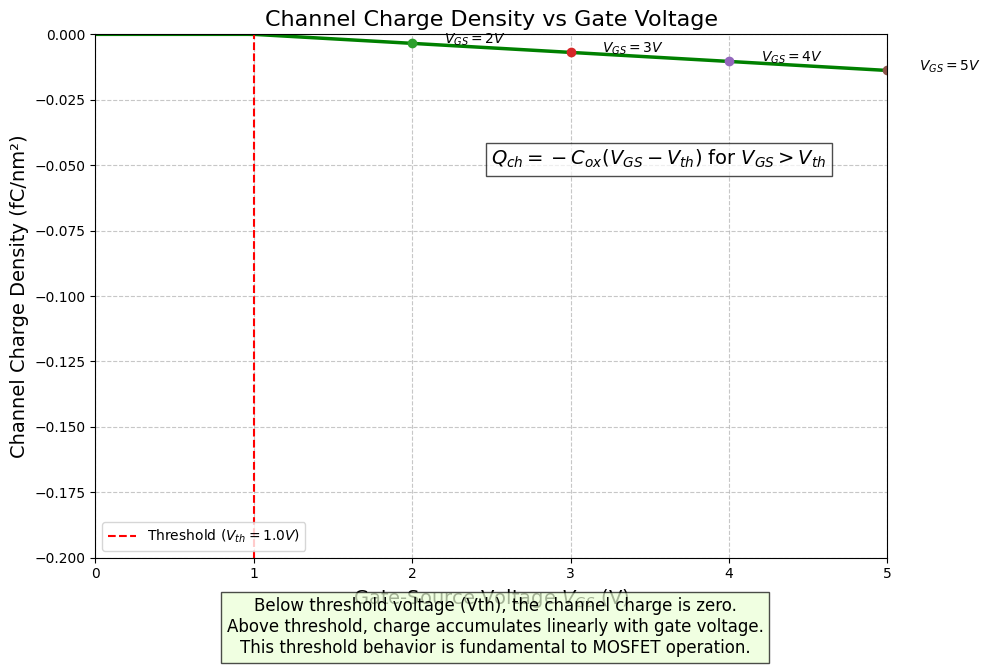

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# MOSFET parameters
V_th = 1.0  # Threshold voltage (V)
t_ox = 10  # Oxide thickness (nm)
epsilon_ox = 3.9 * 8.85e-3  # Oxide permittivity (ε_ox * ε_0) in fF/nm
C_ox = epsilon_ox / t_ox  # Oxide capacitance per unit area (fF/nm²)

# Voltage ranges
V_gs_values = np.array([0, 1, 2, 3, 4, 5])  # Gate-source voltages for specific points
V_gs_range = np.linspace(0, 5, 100)  # Continuous gate voltage range

# Function to calculate charge density in the channel
def Q_channel(V_gs):
    if V_gs <= V_th:
        return 0
    else:
        return -C_ox * (V_gs - V_th)  # Channel charge density (fC/nm²), negative for electrons

# Create figure and axis
plt.figure(figsize=(10, 7))
ax = plt.gca()

# Calculate channel charge for different gate voltages
Q_values = np.array([Q_channel(vgs) for vgs in V_gs_range])

# Plot charge vs V_gs
ax.plot(V_gs_range, Q_values, 'g-', linewidth=2.5)

# Add threshold voltage vertical line
ax.axvline(x=V_th, color='r', linestyle='--', linewidth=1.5, 
           label=f'Threshold ($V_{{th}} = {V_th}V$)')

# Mark specific points
for vgs in V_gs_values:
    if vgs > V_th:  # Only mark points above threshold
        q_channel = Q_channel(vgs)
        ax.plot(vgs, q_channel, 'o', markersize=6, 
               color=plt.rcParams['axes.prop_cycle'].by_key()['color'][np.where(V_gs_values == vgs)[0][0]])
        # Add annotation
        ax.annotate(f'$V_{{GS}}={vgs}V$', 
                   xy=(vgs, q_channel), xytext=(vgs+0.2, q_channel),
                   fontsize=10)

# Setting labels and title
ax.set_xlabel('Gate-Source Voltage $V_{GS}$ (V)', fontsize=14)
ax.set_ylabel('Channel Charge Density (fC/nm²)', fontsize=14)
ax.set_title('Channel Charge Density vs Gate Voltage', fontsize=16)

# Add charge equation
charge_eq = r'$Q_{ch} = -C_{ox}(V_{GS} - V_{th})$ for $V_{GS} > V_{th}$'
ax.text(2.5, -0.05, charge_eq, fontsize=14, bbox=dict(facecolor='white', alpha=0.7))

# Add explanation of threshold voltage behavior
explanation = (
    "Below threshold voltage (Vth), the channel charge is zero.\n"
    "Above threshold, charge accumulates linearly with gate voltage.\n"
    "This threshold behavior is fundamental to MOSFET operation."
)
plt.figtext(0.5, 0.01, explanation, ha="center", fontsize=12, 
            bbox=dict(facecolor='#eaffd5', alpha=0.7))

# Add grid and legend
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='lower left')

# Setting axis limits
ax.set_xlim(0, 5)
ax.set_ylim(-0.2, 0)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig("channel-charge-density.png")
plt.show()

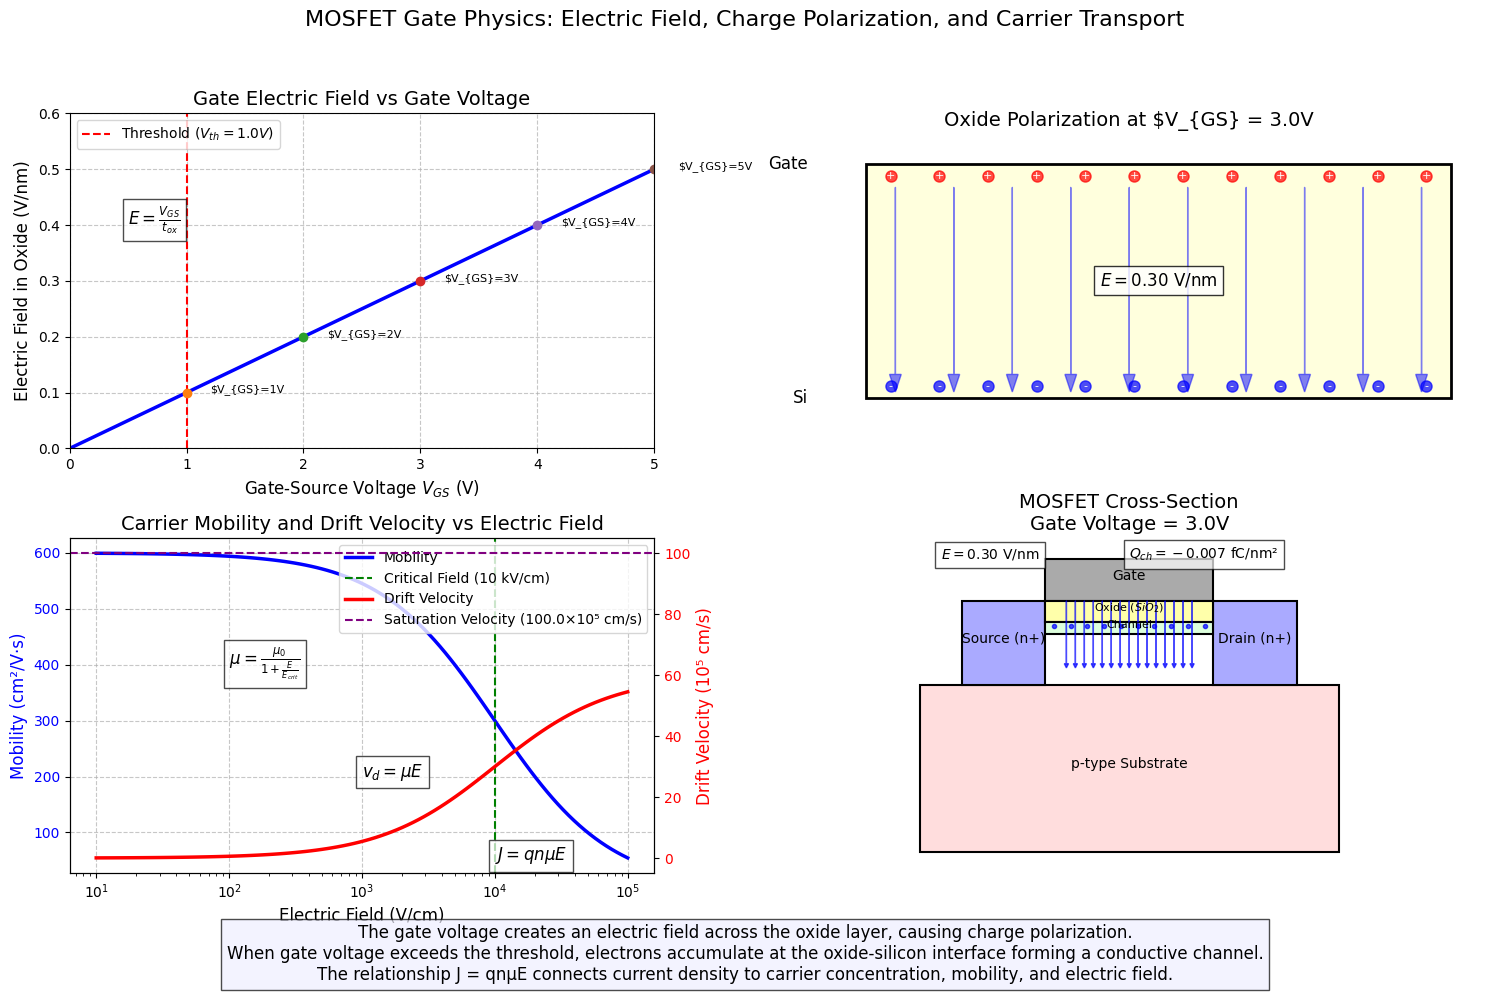

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

# Create a figure with GridSpec for layout control - now 2x2 grid
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1.2])

# MOSFET parameters
V_th = 1.0  # Threshold voltage (V)
t_ox = 10  # Oxide thickness (nm)
epsilon_ox = 3.9 * 8.85e-3  # Oxide permittivity (ε_ox * ε_0) in fF/nm
C_ox = epsilon_ox / t_ox  # Oxide capacitance per unit area (fF/nm²)

# Carrier mobility parameters
mu_0 = 600  # Low-field mobility (cm²/V·s)
E_crit = 1e4  # Critical field for velocity saturation (V/cm)
v_sat = 1e7  # Saturation velocity (cm/s)
T = 300  # Temperature (K)
q = 1.602e-19  # Electron charge (C)
n_i = 1.5e10  # Intrinsic carrier concentration (cm^-3)
n_doping = 1e17  # Doping concentration (cm^-3)

# Voltage ranges
V_gs_values = np.array([0, 1, 2, 3, 4, 5])  # Gate-source voltages for specific points
V_gs_range = np.linspace(0, 5, 100)  # Continuous gate voltage range
E_field_range = np.logspace(1, 5, 100)  # Electric field range (V/cm)

# Function to calculate electric field in the oxide
def E_field(V_gs):
    return V_gs / t_ox  # E-field in V/nm

# Function to calculate charge density in the channel
def Q_channel(V_gs):
    if V_gs <= V_th:
        return 0
    else:
        return -C_ox * (V_gs - V_th)  # Channel charge density (fC/nm²), negative for electrons

# Function to calculate mobility vs. electric field (with velocity saturation)
def mobility(E):
    # Mobility model with velocity saturation
    # E is in V/cm
    return mu_0 / (1 + E/E_crit)

# Function to calculate drift velocity vs. electric field
def drift_velocity(E):
    # v_d = μE (with saturation)
    # E is in V/cm, result in cm/s
    return mobility(E) * E

# Electric Field vs Gate Voltage Plot (Top Left)
ax1 = fig.add_subplot(gs[0, 0])

# Calculate electric field for different gate voltages
E_field_values = np.array([E_field(vgs) for vgs in V_gs_range])

# Plot E-field vs V_gs
ax1.plot(V_gs_range, E_field_values, 'b-', linewidth=2.5)

# Add threshold voltage vertical line
ax1.axvline(x=V_th, color='r', linestyle='--', linewidth=1.5, 
            label=f'Threshold ($V_{{th}} = {V_th}V$)')

# Mark specific points
for vgs in V_gs_values:
    if vgs > 0:  # Skip 0V to avoid clutter
        e_field = E_field(vgs)
        ax1.plot(vgs, e_field, 'o', markersize=6, 
                color=plt.rcParams['axes.prop_cycle'].by_key()['color'][np.where(V_gs_values == vgs)[0][0]])
        # Add annotation
        ax1.annotate(f'$V_{{GS}}={vgs}V', xy=(vgs, e_field), xytext=(vgs+0.2, e_field), fontsize=8)

# Setting labels and title
ax1.set_xlabel('Gate-Source Voltage $V_{GS}$ (V)', fontsize=12)
ax1.set_ylabel('Electric Field in Oxide (V/nm)', fontsize=12)
ax1.set_title('Gate Electric Field vs Gate Voltage', fontsize=14)

# Add E-field equation
e_field_eq = r'$E = \frac{V_{GS}}{t_{ox}}$'

ax1.text(0.5, 0.4, e_field_eq, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

# Add grid and legend
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')

# Setting axis limits
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 0.6)

# Oxide Polarization Visualization (Top Right)
ax2 = fig.add_subplot(gs[0, 1])

# Create a function to visualize the polarization in the oxide for a given gate voltage
def draw_oxide_polarization(ax, V_gs):
    # Define oxide dimensions
    width = 10
    height = 4
    
    # Create oxide rectangle
    oxide = Rectangle((0, 0), width, height, fc='#FFFFDD', ec='k', lw=2)
    ax.add_patch(oxide)
    
    # Label top and bottom of oxide
    ax.text(-1, height, 'Gate', fontsize=12, ha='right', va='center')
    ax.text(-1, 0, 'Si', fontsize=12, ha='right', va='center')
    
    # Draw positive charges (holes) at the top of the oxide
    if V_gs > 0:
        charge_density = min(1.0, V_gs / 5.0)  # Normalize to max V_gs
        num_charges = int(20 * charge_density)
        
        for i in range(num_charges):
            x_pos = width * (i + 0.5) / num_charges
            # Top (positive charges)
            ax.plot(x_pos, height-0.2, 'o', markersize=8, color='red', alpha=0.7)
            ax.text(x_pos, height-0.2, '+', color='white', ha='center', va='center', fontsize=8)
            
            # Bottom (negative charges)
            ax.plot(x_pos, 0.2, 'o', markersize=8, color='blue', alpha=0.7)
            ax.text(x_pos, 0.2, '-', color='white', ha='center', va='center', fontsize=8)
        
        # Draw electric field lines
        num_lines = min(10, num_charges)
        for i in range(num_lines):
            x_pos = width * (i + 0.5) / num_lines
            arrow_length = height - 0.8
            ax.arrow(x_pos, height-0.4, 0, -arrow_length, head_width=0.2, head_length=0.3, 
                    fc='blue', ec='blue', alpha=0.5)
    
    # Title and axis settings
    ax.set_title(f'Oxide Polarization at $V_{{GS}} = {V_gs}V'
, fontsize=14)
    ax.set_xlim(-1.5, width+0.5)
    ax.set_ylim(-0.5, height+0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Add electric field value
    if V_gs > 0:
        e_value = E_field(V_gs)
        ax.text(width/2, height/2, f'$E = {e_value:.2f}$ V/nm', fontsize=12, 
                ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))

# Draw for a specific gate voltage
draw_oxide_polarization(ax2, 3.0)

# Carrier Mobility and Drift Velocity vs Electric Field (Bottom Left)
ax3 = fig.add_subplot(gs[1, 0])

# Calculate mobility and drift velocity for different electric fields
mobility_values = np.array([mobility(E) for E in E_field_range])
velocity_values = np.array([drift_velocity(E) for E in E_field_range])

# Plot mobility vs E-field
ax3.semilogx(E_field_range, mobility_values, 'b-', linewidth=2.5, label='Mobility')
ax3.set_xlabel('Electric Field (V/cm)', fontsize=12)
ax3.set_ylabel('Mobility (cm²/V·s)', fontsize=12, color='blue')
ax3.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for drift velocity
ax3_twin = ax3.twinx()
ax3_twin.semilogx(E_field_range, velocity_values/1e5, 'r-', linewidth=2.5, label='Drift Velocity')
ax3_twin.set_ylabel('Drift Velocity (10⁵ cm/s)', fontsize=12, color='red')
ax3_twin.tick_params(axis='y', labelcolor='red')

# Mark critical field and saturation velocity
ax3.axvline(x=E_crit, color='g', linestyle='--', linewidth=1.5, 
           label=f'Critical Field ({E_crit/1000:.0f} kV/cm)')
ax3_twin.axhline(y=v_sat/1e5, color='purple', linestyle='--', linewidth=1.5,
              label=f'Saturation Velocity ({v_sat/1e5:.1f}×10⁵ cm/s)')

# Add title and equations
ax3.set_title('Carrier Mobility and Drift Velocity vs Electric Field', fontsize=14)
mobility_eq = r'$\mu = \frac{\mu_0}{1 + \frac{E}{E_{crit}}}$'

ax3.text(100, 400, mobility_eq, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

drift_eq = r'$v_d = \mu E$'

ax3.text(1000, 200, drift_eq, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

current_eq = r'$J = q n \mu E$'

ax3.text(10000, 50, current_eq, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

# Add grid
ax3.grid(True, linestyle='--', alpha=0.7)

# Add legends for both axes
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# MOSFET Cross-Section with E-field Visualization (Bottom Right)
ax4 = fig.add_subplot(gs[1, 1])

# Selected V_gs for visualization
selected_V_gs = 3.0  # V

# Draw MOSFET structure
# Dimensions in arbitrary units for visualization
width = 10
height = 6
gate_width = 4
oxide_height = 0.5
channel_height = 0.3

# Define components
substrate = Rectangle((0, 0), width, height-2, fc='#FFDDDD', ec='k', lw=1.5)
source = Rectangle((1, height-2), 2, 2, fc='#AAAAFF', ec='k', lw=1.5)
drain = Rectangle((width-3, height-2), 2, 2, fc='#AAAAFF', ec='k', lw=1.5)
gate = Rectangle((width/2-gate_width/2, height), gate_width, 1, fc='#AAAAAA', ec='k', lw=1.5)
oxide = Rectangle((width/2-gate_width/2, height-oxide_height), gate_width, oxide_height, fc='#FFFFAA', ec='k', lw=1.5)
channel = Rectangle((width/2-gate_width/2, height-oxide_height-channel_height), gate_width, channel_height, fc='#DDFFDD', ec='k', lw=1.5)

# Add components to the plot
ax4.add_patch(substrate)
ax4.add_patch(source)
ax4.add_patch(drain)
ax4.add_patch(gate)
ax4.add_patch(oxide)
ax4.add_patch(channel)

# Add labels
ax4.text(width/2, height+0.5, 'Gate', ha='center')
ax4.text(2, height-1, 'Source (n+)', ha='center')
ax4.text(width-2, height-1, 'Drain (n+)', ha='center')
ax4.text(width/2, height-oxide_height/2, 'Oxide ($SiO_2$)', ha='center', fontsize=8)
ax4.text(width/2, height-oxide_height-channel_height/2, 'Channel', ha='center', fontsize=8)
ax4.text(width/2, height/2-1, 'p-type Substrate', ha='center')

# Visualize electric field lines
if selected_V_gs > 0:
    # Draw electric field lines from gate to channel
    num_lines = 15
    line_positions = np.linspace(width/2-gate_width/2+0.5, width/2+gate_width/2-0.5, num_lines)
    
    # Adjust field intensity based on gate voltage
    field_intensity = selected_V_gs / V_th if selected_V_gs > V_th else selected_V_gs / (2*V_th)
    arrow_length = oxide_height * field_intensity
    
    for x_pos in line_positions:
        # Draw field line from gate to channel
        ax4.arrow(x_pos, height, 0, -arrow_length, head_width=0.1, head_length=0.1, 
                 fc='blue', ec='blue', alpha=0.7)
    
    # Draw charge accumulation at the interface
    if selected_V_gs > V_th:
        charge_density = abs(Q_channel(selected_V_gs)) / abs(Q_channel(5))  # Normalize to max charge
        for x_pos in np.linspace(width/2-gate_width/2+0.2, width/2+gate_width/2-0.2, int(20*charge_density)):
            ax4.plot(x_pos, height-oxide_height-0.1, 'o', markersize=3, color='#0000FF', alpha=0.7)

# Add a title with selected gate voltage
ax4.set_title(f'MOSFET Cross-Section\nGate Voltage = {selected_V_gs}V', fontsize=14)

# Setting axis properties
ax4.set_aspect('equal')
ax4.set_xlim(-0.5, width+0.5)
ax4.set_ylim(-0.5, height+1.5)
ax4.axis('off')

# Add annotations for electric field and charge
if selected_V_gs > 0:
    # E-field equation
    e_value = E_field(selected_V_gs)
    ax4.text(0.5, height+1, f'$E = {e_value:.2f}$ V/nm', fontsize=10, 
             bbox=dict(facecolor='white', alpha=0.7))
    
    # Charge equation if above threshold
    if selected_V_gs > V_th:
        q_value = Q_channel(selected_V_gs)
        ax4.text(width-5, height+1, f'$Q_{{ch}} = {q_value:.3f}$ fC/nm²', fontsize=10, 
                 bbox=dict(facecolor='white', alpha=0.7))

# Add overall title explaining the physics
fig.suptitle('MOSFET Gate Physics: Electric Field, Charge Polarization, and Carrier Transport', fontsize=16, y=0.98)

# Add explanation text at the bottom
explanation = (
    "The gate voltage creates an electric field across the oxide layer, causing charge polarization.\n"
    "When gate voltage exceeds the threshold, electrons accumulate at the oxide-silicon interface forming a conductive channel.\n"
    "The relationship J = qnμE connects current density to carrier concentration, mobility, and electric field."
)
plt.figtext(0.5, 0.01, explanation, ha='center', fontsize=12, 
            bbox=dict(facecolor='#EEEEFF', alpha=0.7))

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Make room for suptitle and explanation
plt.show()

## Delta


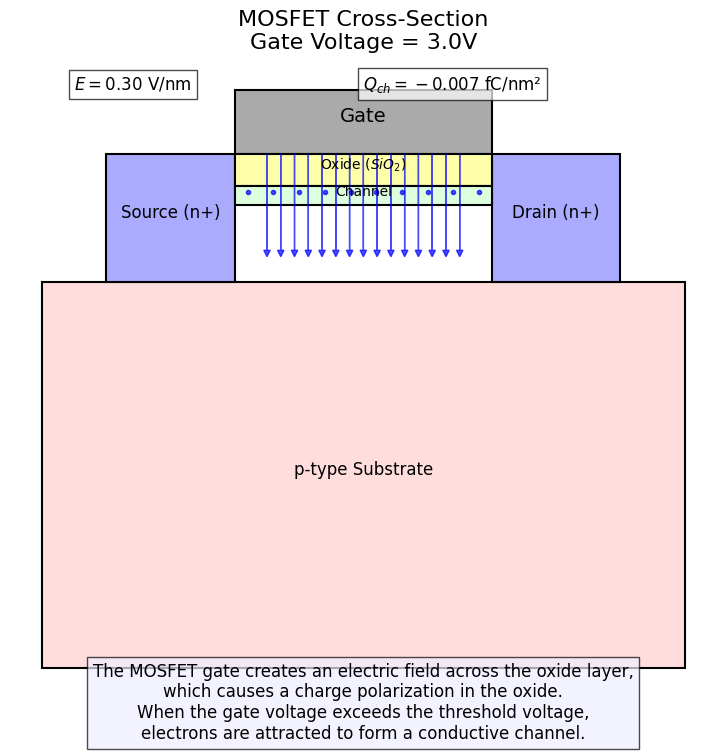

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Create a figure
fig = plt.figure(figsize=(10, 8))

# MOSFET parameters
V_th = 1.0  # Threshold voltage (V)
t_ox = 10  # Oxide thickness (nm)
epsilon_ox = 3.9 * 8.85e-3  # Oxide permittivity (ε_ox * ε_0) in fF/nm
C_ox = epsilon_ox / t_ox  # Oxide capacitance per unit area (fF/nm²)

# Function to calculate electric field in the oxide
def E_field(V_gs):
    return V_gs / t_ox  # E-field in V/nm

# Function to calculate charge density in the channel
def Q_channel(V_gs):
    if V_gs <= V_th:
        return 0
    else:
        return -C_ox * (V_gs - V_th)  # Channel charge density (fC/nm²), negative for electrons

# Selected V_gs for visualization - can be changed by user
selected_V_gs = 3.0  # V

# Draw MOSFET structure
# Dimensions in arbitrary units for visualization
width = 10
height = 8
gate_width = 4
oxide_height = 0.5
channel_height = 0.3

# Define components
substrate = Rectangle((0, 0), width, height-2, fc='#FFDDDD', ec='k', lw=1.5)
source = Rectangle((1, height-2), 2, 2, fc='#AAAAFF', ec='k', lw=1.5)
drain = Rectangle((width-3, height-2), 2, 2, fc='#AAAAFF', ec='k', lw=1.5)
gate = Rectangle((width/2-gate_width/2, height), gate_width, 1, fc='#AAAAAA', ec='k', lw=1.5)
oxide = Rectangle((width/2-gate_width/2, height-oxide_height), gate_width, oxide_height, fc='#FFFFAA', ec='k', lw=1.5)
channel = Rectangle((width/2-gate_width/2, height-oxide_height-channel_height), gate_width, channel_height, fc='#DDFFDD', ec='k', lw=1.5)

# Add components to the plot
ax = plt.gca()
ax.add_patch(substrate)
ax.add_patch(source)
ax.add_patch(drain)
ax.add_patch(gate)
ax.add_patch(oxide)
ax.add_patch(channel)

# Add labels
ax.text(width/2, height+0.5, 'Gate', ha='center', fontsize=14)
ax.text(2, height-1, 'Source (n+)', ha='center', fontsize=12)
ax.text(width-2, height-1, 'Drain (n+)', ha='center', fontsize=12)
ax.text(width/2, height-oxide_height/2, 'Oxide ($SiO_2$)', ha='center', fontsize=10)
ax.text(width/2, height-oxide_height-channel_height/2, 'Channel', ha='center', fontsize=10)
ax.text(width/2, height/2-1, 'p-type Substrate', ha='center', fontsize=12)

# Visualize electric field lines
if selected_V_gs > 0:
    # Draw electric field lines from gate to channel
    num_lines = 15
    line_positions = np.linspace(width/2-gate_width/2+0.5, width/2+gate_width/2-0.5, num_lines)
    
    # Adjust field intensity based on gate voltage
    field_intensity = selected_V_gs / V_th if selected_V_gs > V_th else selected_V_gs / (2*V_th)
    arrow_length = oxide_height * field_intensity
    
    for x_pos in line_positions:
        # Draw field line from gate to channel
        ax.arrow(x_pos, height, 0, -arrow_length, head_width=0.1, head_length=0.1, 
                 fc='blue', ec='blue', alpha=0.7)
    
    # Draw charge accumulation at the interface
    if selected_V_gs > V_th:
        charge_density = abs(Q_channel(selected_V_gs)) / abs(Q_channel(5))  # Normalize to max charge
        for x_pos in np.linspace(width/2-gate_width/2+0.2, width/2+gate_width/2-0.2, int(20*charge_density)):
            ax.plot(x_pos, height-oxide_height-0.1, 'o', markersize=3, color='#0000FF', alpha=0.7)

# Add a title with selected gate voltage
plt.title(f'MOSFET Cross-Section\nGate Voltage = {selected_V_gs}V', fontsize=16)

# Setting axis properties
ax.set_aspect('equal')
ax.set_xlim(-0.5, width+0.5)
ax.set_ylim(-0.5, height+1.5)
ax.axis('off')

# Add annotations for electric field and charge
if selected_V_gs > 0:
    # E-field equation
    e_value = E_field(selected_V_gs)
    ax.text(0.5, height+1, f'$E = {e_value:.2f}$ V/nm', fontsize=12, 
             bbox=dict(facecolor='white', alpha=0.7))
    
    # Charge equation if above threshold
    if selected_V_gs > V_th:
        q_value = Q_channel(selected_V_gs)
        ax.text(width-5, height+1, f'$Q_{{ch}} = {q_value:.3f}$ fC/nm²', fontsize=12, 
                 bbox=dict(facecolor='white', alpha=0.7))

# Add explanatory text about the physics
explanation_text = (
    "The MOSFET gate creates an electric field across the oxide layer,\n"
    "which causes a charge polarization in the oxide.\n"
    "When the gate voltage exceeds the threshold voltage,\n"
    "electrons are attracted to form a conductive channel."
)
plt.figtext(0.5, 0.02, explanation_text, ha='center', fontsize=12, 
            bbox=dict(facecolor='#EEEEFF', alpha=0.7))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
#plt.savefig("Mosfetcross.png")
plt.show()

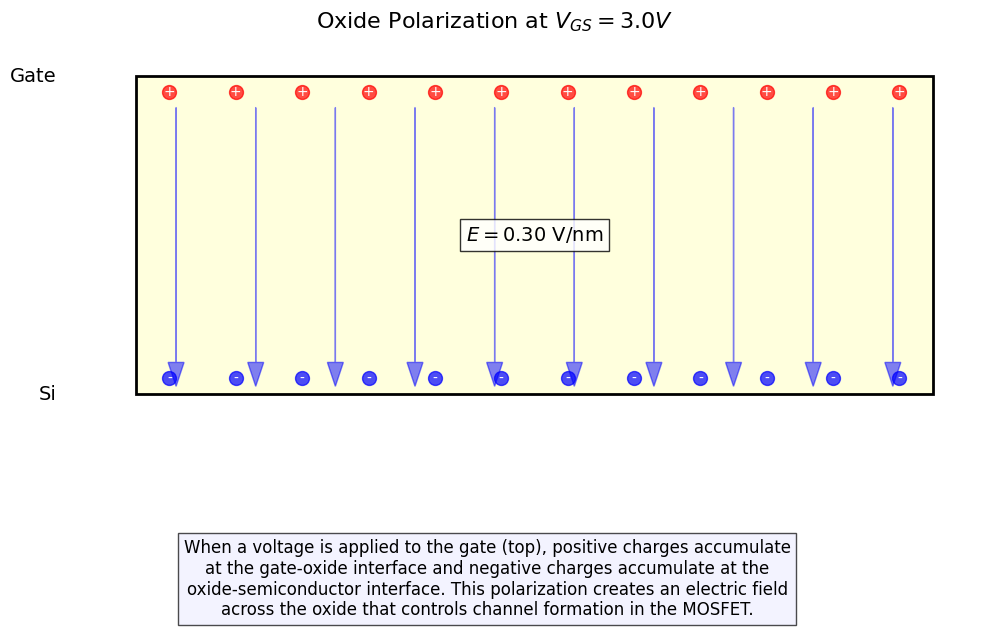

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Create a figure
fig = plt.figure(figsize=(10, 8))

# MOSFET parameters
V_th = 1.0  # Threshold voltage (V)
t_ox = 10  # Oxide thickness (nm)

# Function to calculate electric field in the oxide
def E_field(V_gs):
    return V_gs / t_ox  # E-field in V/nm

# Selected gate voltage for visualization - can be changed by user
selected_V_gs = 3.0  # V

# Define oxide dimensions
width = 10
height = 4

# Create function to visualize the polarization in the oxide
def draw_oxide_polarization(V_gs):
    ax = plt.gca()
    
    # Create oxide rectangle
    oxide = Rectangle((0, 0), width, height, fc='#FFFFDD', ec='k', lw=2)
    ax.add_patch(oxide)
    
    # Label top and bottom of oxide
    ax.text(-1, height, 'Gate', fontsize=14, ha='right', va='center')
    ax.text(-1, 0, 'Si', fontsize=14, ha='right', va='center')
    
    # Draw positive charges (holes) at the top of the oxide
    if V_gs > 0:
        charge_density = min(1.0, V_gs / 5.0)  # Normalize to max V_gs
        num_charges = int(20 * charge_density)
        
        for i in range(num_charges):
            x_pos = width * (i + 0.5) / num_charges
            # Top (positive charges)
            ax.plot(x_pos, height-0.2, 'o', markersize=10, color='red', alpha=0.7)
            ax.text(x_pos, height-0.2, '+', color='white', ha='center', va='center', fontsize=10)
            
            # Bottom (negative charges)
            ax.plot(x_pos, 0.2, 'o', markersize=10, color='blue', alpha=0.7)
            ax.text(x_pos, 0.2, '-', color='white', ha='center', va='center', fontsize=10)
        
        # Draw electric field lines
        num_lines = min(10, num_charges)
        for i in range(num_lines):
            x_pos = width * (i + 0.5) / num_lines
            arrow_length = height - 0.8
            ax.arrow(x_pos, height-0.4, 0, -arrow_length, head_width=0.2, head_length=0.3, 
                    fc='blue', ec='blue', alpha=0.5)
    
    # Add electric field value
    if V_gs > 0:
        e_value = E_field(V_gs)
        ax.text(width/2, height/2, f'$E = {e_value:.2f}$ V/nm', fontsize=14, 
                ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))
    
    # Title and axis settings
    plt.title(f'Oxide Polarization at $V_{{GS}} = {V_gs}V$', fontsize=16)
    plt.xlim(-1.5, width+0.5)
    plt.ylim(-0.5, height+0.5)
    ax.set_aspect('equal')
    ax.axis('off')

# Draw for the selected gate voltage
draw_oxide_polarization(selected_V_gs)

# Add explanatory text
explanation_text = (
    "When a voltage is applied to the gate (top), positive charges accumulate\n"
    "at the gate-oxide interface and negative charges accumulate at the\n"
    "oxide-semiconductor interface. This polarization creates an electric field\n"
    "across the oxide that controls channel formation in the MOSFET."
)
plt.figtext(0.5, 0.05, explanation_text, ha='center', fontsize=12, 
            bbox=dict(facecolor='#EEEEFF', alpha=0.7))

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
# plt.savefig("Oxide-polarization.png")
plt.show()

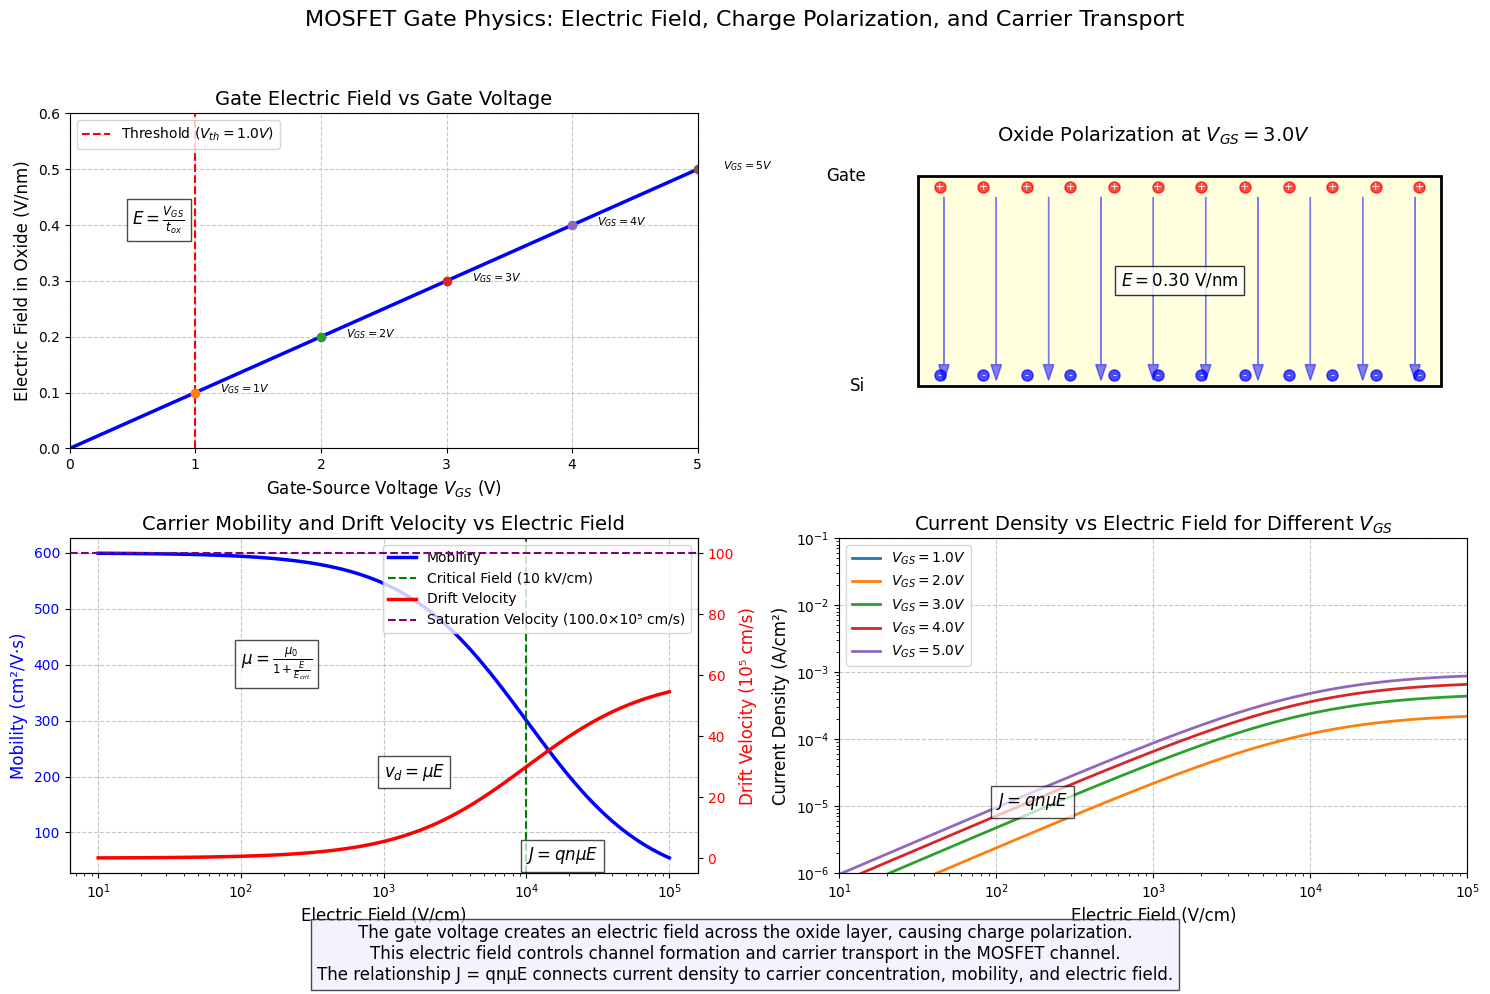

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

# Create a figure with GridSpec for layout control - 2x1 grid (vertical layout)
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

# MOSFET parameters
V_th = 1.0  # Threshold voltage (V)
t_ox = 10  # Oxide thickness (nm)
epsilon_ox = 3.9 * 8.85e-3  # Oxide permittivity (ε_ox * ε_0) in fF/nm
C_ox = epsilon_ox / t_ox  # Oxide capacitance per unit area (fF/nm²)

# Carrier mobility parameters
mu_0 = 600  # Low-field mobility (cm²/V·s)
E_crit = 1e4  # Critical field for velocity saturation (V/cm)
v_sat = 1e7  # Saturation velocity (cm/s)
T = 300  # Temperature (K)
q = 1.602e-19  # Electron charge (C)
n_i = 1.5e10  # Intrinsic carrier concentration (cm^-3)
n_doping = 1e17  # Doping concentration (cm^-3)

# Voltage ranges
V_gs_values = np.array([0, 1, 2, 3, 4, 5])  # Gate-source voltages for specific points
V_gs_range = np.linspace(0, 5, 100)  # Continuous gate voltage range
E_field_range = np.logspace(1, 5, 100)  # Electric field range (V/cm)

# Function to calculate electric field in the oxide
def E_field(V_gs):
    return V_gs / t_ox  # E-field in V/nm

# Function to calculate charge density in the channel
def Q_channel(V_gs):
    if V_gs <= V_th:
        return 0
    else:
        return -C_ox * (V_gs - V_th)  # Channel charge density (fC/nm²), negative for electrons

# Function to calculate mobility vs. electric field (with velocity saturation)
def mobility(E):
    # Mobility model with velocity saturation
    # E is in V/cm
    return mu_0 / (1 + E/E_crit)

# Function to calculate drift velocity vs. electric field
def drift_velocity(E):
    # v_d = μE (with saturation)
    # E is in V/cm, result in cm/s
    return mobility(E) * E

# Function to calculate current density
def current_density(E, n):
    # J = qnμE
    # E is in V/cm, n in cm^-3, result in A/cm^2
    return q * n * mobility(E) * E * 1e-8  # Convert to A/cm^2

# Electric Field vs Gate Voltage Plot (Top Left)
ax1 = fig.add_subplot(gs[0, 0])

# Calculate electric field for different gate voltages
E_field_values = np.array([E_field(vgs) for vgs in V_gs_range])

# Plot E-field vs V_gs
ax1.plot(V_gs_range, E_field_values, 'b-', linewidth=2.5)

# Add threshold voltage vertical line
ax1.axvline(x=V_th, color='r', linestyle='--', linewidth=1.5, 
            label=f'Threshold ($V_{{th}} = {V_th}V$)')

# Mark specific points
for vgs in V_gs_values:
    if vgs > 0:  # Skip 0V to avoid clutter
        e_field = E_field(vgs)
        ax1.plot(vgs, e_field, 'o', markersize=6, 
                color=plt.rcParams['axes.prop_cycle'].by_key()['color'][np.where(V_gs_values == vgs)[0][0]])
        # Add annotation
        ax1.annotate(f'$V_{{GS}}={vgs}V$', 
                    xy=(vgs, e_field), xytext=(vgs+0.2, e_field),
                    fontsize=8)

# Setting labels and title
ax1.set_xlabel('Gate-Source Voltage $V_{GS}$ (V)', fontsize=12)
ax1.set_ylabel('Electric Field in Oxide (V/nm)', fontsize=12)
ax1.set_title('Gate Electric Field vs Gate Voltage', fontsize=14)

# Add E-field equation
e_field_eq = r'$E = \frac{V_{GS}}{t_{ox}}$'
ax1.text(0.5, 0.4, e_field_eq, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

# Add grid and legend
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')

# Setting axis limits
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 0.6)

# Oxide Polarization Visualization (Top Right)
ax2 = fig.add_subplot(gs[0, 1])

# Create a function to visualize the polarization in the oxide for a given gate voltage
def draw_oxide_polarization(ax, V_gs):
    # Define oxide dimensions
    width = 10
    height = 4
    
    # Create oxide rectangle
    oxide = Rectangle((0, 0), width, height, fc='#FFFFDD', ec='k', lw=2)
    ax.add_patch(oxide)
    
    # Label top and bottom of oxide
    ax.text(-1, height, 'Gate', fontsize=12, ha='right', va='center')
    ax.text(-1, 0, 'Si', fontsize=12, ha='right', va='center')
    
    # Draw positive charges (holes) at the top of the oxide
    if V_gs > 0:
        charge_density = min(1.0, V_gs / 5.0)  # Normalize to max V_gs
        num_charges = int(20 * charge_density)
        
        for i in range(num_charges):
            x_pos = width * (i + 0.5) / num_charges
            # Top (positive charges)
            ax.plot(x_pos, height-0.2, 'o', markersize=8, color='red', alpha=0.7)
            ax.text(x_pos, height-0.2, '+', color='white', ha='center', va='center', fontsize=8)
            
            # Bottom (negative charges)
            ax.plot(x_pos, 0.2, 'o', markersize=8, color='blue', alpha=0.7)
            ax.text(x_pos, 0.2, '-', color='white', ha='center', va='center', fontsize=8)
        
        # Draw electric field lines
        num_lines = min(10, num_charges)
        for i in range(num_lines):
            x_pos = width * (i + 0.5) / num_lines
            arrow_length = height - 0.8
            ax.arrow(x_pos, height-0.4, 0, -arrow_length, head_width=0.2, head_length=0.3, 
                    fc='blue', ec='blue', alpha=0.5)
    
    # Title and axis settings
    ax.set_title(f'Oxide Polarization at $V_{{GS}} = {V_gs}V$', fontsize=14)
    ax.set_xlim(-1.5, width+0.5)
    ax.set_ylim(-0.5, height+0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Add electric field value
    if V_gs > 0:
        e_value = E_field(V_gs)
        ax.text(width/2, height/2, f'$E = {e_value:.2f}$ V/nm', fontsize=12, 
                ha='center', va='center', bbox=dict(facecolor='white', alpha=0.8))

# Draw for a specific gate voltage
draw_oxide_polarization(ax2, 3.0)

# Carrier Mobility and Drift Velocity vs Electric Field (Bottom Left)
ax3 = fig.add_subplot(gs[1, 0])

# Calculate mobility and drift velocity for different electric fields
mobility_values = np.array([mobility(E) for E in E_field_range])
velocity_values = np.array([drift_velocity(E) for E in E_field_range])

# Plot mobility vs E-field
ax3.semilogx(E_field_range, mobility_values, 'b-', linewidth=2.5, label='Mobility')
ax3.set_xlabel('Electric Field (V/cm)', fontsize=12)
ax3.set_ylabel('Mobility (cm²/V·s)', fontsize=12, color='blue')
ax3.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for drift velocity
ax3_twin = ax3.twinx()
ax3_twin.semilogx(E_field_range, velocity_values/1e5, 'r-', linewidth=2.5, label='Drift Velocity')
ax3_twin.set_ylabel('Drift Velocity (10⁵ cm/s)', fontsize=12, color='red')
ax3_twin.tick_params(axis='y', labelcolor='red')

# Mark critical field and saturation velocity
ax3.axvline(x=E_crit, color='g', linestyle='--', linewidth=1.5, 
           label=f'Critical Field ({E_crit/1000:.0f} kV/cm)')
ax3_twin.axhline(y=v_sat/1e5, color='purple', linestyle='--', linewidth=1.5,
              label=f'Saturation Velocity ({v_sat/1e5:.1f}×10⁵ cm/s)')

# Add title and equations
ax3.set_title('Carrier Mobility and Drift Velocity vs Electric Field', fontsize=14)
mobility_eq = r'$\mu = \frac{\mu_0}{1 + \frac{E}{E_{crit}}}$'
ax3.text(100, 400, mobility_eq, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

drift_eq = r'$v_d = \mu E$'
ax3.text(1000, 200, drift_eq, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

current_eq = r'$J = q n \mu E$'
ax3.text(10000, 50, current_eq, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

# Add grid
ax3.grid(True, linestyle='--', alpha=0.7)

# Add legends for both axes
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Carrier Concentration and Current Density vs Electric Field (Bottom Right)
ax4 = fig.add_subplot(gs[1, 1])

# Calculate carrier concentration based on gate voltages exceeding threshold
# Simplified model: n ∝ (Vgs - Vth) when Vgs > Vth
def carrier_concentration(V_gs):
    if V_gs <= V_th:
        return 1e10  # Very small concentration below threshold
    else:
        return n_doping * (V_gs - V_th) / 4  # Simplified model

# Different gate voltages to show
V_gs_for_current = [1.0, 2.0, 3.0, 4.0, 5.0]

# Plot current density vs E-field for different gate voltages
for vgs in V_gs_for_current:
    n = carrier_concentration(vgs)
    J_values = np.array([current_density(E, n) for E in E_field_range])
    
    ax4.loglog(E_field_range, J_values, linewidth=2, 
              label=f'$V_{{GS}} = {vgs}V$')

# Add title and labels
ax4.set_title('Current Density vs Electric Field for Different $V_{GS}$', fontsize=14)
ax4.set_xlabel('Electric Field (V/cm)', fontsize=12)
ax4.set_ylabel('Current Density (A/cm²)', fontsize=12)

# Add equation
ax4.text(100, 1e-5, r'$J = q n \mu E$', fontsize=12, 
        bbox=dict(facecolor='white', alpha=0.7))

# Add grid and legend
ax4.grid(True, linestyle='--', alpha=0.7)
ax4.legend(loc='upper left')

# Set axis limits
ax4.set_xlim(E_field_range[0], E_field_range[-1])
ax4.set_ylim(1e-6, 1e-1)

# Add overall title explaining the physics
fig.suptitle('MOSFET Gate Physics: Electric Field, Charge Polarization, and Carrier Transport', fontsize=16, y=0.98)

# Add explanation text at the bottom
explanation = (
    "The gate voltage creates an electric field across the oxide layer, causing charge polarization.\n"
    "This electric field controls channel formation and carrier transport in the MOSFET channel.\n"
    "The relationship J = qnμE connects current density to carrier concentration, mobility, and electric field."
)
plt.figtext(0.5, 0.01, explanation, ha='center', fontsize=12, 
            bbox=dict(facecolor='#EEEEFF', alpha=0.7))

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Make room for suptitle and explanation
# plt.savefig("Mosfet-charts.png")
plt.show()

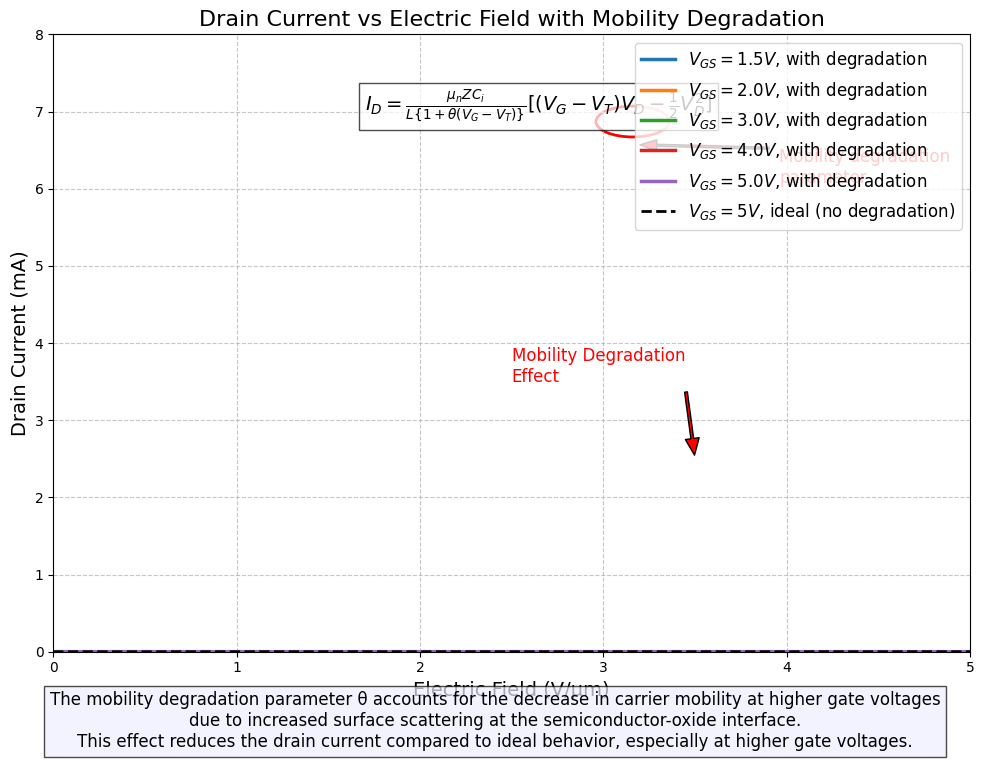

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# MOSFET parameters
V_th = 1.0  # Threshold voltage (V)
t_ox = 10  # Oxide thickness (nm)
epsilon_ox = 3.9 * 8.85e-3  # Oxide permittivity (ε_ox * ε_0) in fF/nm
C_ox = epsilon_ox / t_ox  # Gate capacitance per unit area (fF/nm²)

# Parameters for drain current model
mu_n = 600  # Low-field electron mobility (cm²/V·s)
Z = 10  # Channel width (µm)
Ci = C_ox * 1e-9  # Gate capacitance per unit area (F/cm²)
L = 1.0  # Channel length (µm)
theta = 0.15  # Mobility degradation parameter (V⁻¹)

# Function to calculate drain current with mobility degradation
def drain_current(V_g, V_d, theta):
    if V_g <= V_th:
        return 0  # No current below threshold
    
    # Calculate mobility degradation factor
    mobility_factor = 1 / (1 + theta * (V_g - V_th))
    
    # Calculate drain current using the equation
    I_d = (mu_n * Z * Ci) / L * mobility_factor * ((V_g - V_th) * V_d - 0.5 * V_d**2)
    
    return I_d * 1e3  # Convert to mA

# Calculate drain current vs electric field for different gate voltages
V_gs_for_current = [1.5, 2.0, 3.0, 4.0, 5.0]  # Different gate voltages
V_ds_range = np.linspace(0, 5, 100)  # Drain-source voltage range
E_field_values = V_ds_range / L  # Approximate longitudinal E-field (V/µm)

# Plot drain current vs electric field for different gate voltages
for vgs in V_gs_for_current:
    # Calculate current with mobility degradation
    I_d_values = np.array([drain_current(vgs, vds, theta) for vds in V_ds_range])
    
    ax.plot(E_field_values, I_d_values, linewidth=2.5, 
            label=f'$V_{{GS}} = {vgs}V$, with degradation')
    
    # Calculate current without mobility degradation for comparison (theta = 0)
    if vgs == 5.0:  # Only show for highest Vgs to avoid clutter
        I_d_ideal = np.array([drain_current(vgs, vds, 0) for vds in V_ds_range])
        ax.plot(E_field_values, I_d_ideal, 'k--', linewidth=2, 
                label='$V_{GS} = 5V$, ideal (no degradation)')

# Add annotations for mobility degradation effect
ax.annotate('Mobility Degradation\nEffect', xy=(3.5, 2.5), xytext=(2.5, 3.5),
             arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10),
             fontsize=12, color='red')

# Circle the theta parameter in the equation
equation_x, equation_y = 1.7, 7.0
ax.text(equation_x, equation_y, r'$I_D = \frac{\mu_n Z C_i}{L\{1 + \theta(V_G - V_T)\}} [(V_G - V_T)V_D - \frac{1}{2}V_D^2]$', 
        fontsize=14, bbox=dict(facecolor='white', alpha=0.7))

# Add a circle around theta
circle_x, circle_y = equation_x + 1.46, equation_y - 0.13  # Adjust these coordinates to circle the theta
circle = plt.Circle((circle_x, circle_y), 0.2, fill=False, edgecolor='red', linewidth=2)
ax.add_patch(circle)

# Add a label for the mobility degradation parameter
ax.annotate('Mobility degradation\nparameter', xy=(circle_x, circle_y-0.3), xytext=(circle_x+0.8, circle_y-0.8),
            arrowprops=dict(facecolor='red', shrink=0.05, width=1.5, headwidth=8),
            fontsize=12, color='red')

# Add title and labels
ax.set_title('Drain Current vs Electric Field with Mobility Degradation', fontsize=16)
ax.set_xlabel('Electric Field (V/µm)', fontsize=14)
ax.set_ylabel('Drain Current (mA)', fontsize=14)

# Add grid and legend
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='upper right', fontsize=12)

# Setting axis limits
ax.set_xlim(0, 5)
ax.set_ylim(0, 8)

# Explanation
explanation = (
    "The mobility degradation parameter θ accounts for the decrease in carrier mobility at higher gate voltages\n"
    "due to increased surface scattering at the semiconductor-oxide interface.\n"
    "This effect reduces the drain current compared to ideal behavior, especially at higher gate voltages."
)
plt.figtext(0.5, 0.01, explanation, ha='center', fontsize=12, 
            bbox=dict(facecolor='#EEEEFF', alpha=0.7))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()